https://www.joinquant.com/view/community/detail/318d38fafda6bf7130587c48853817f8?type=1

备注：该研究有一套纯手写的回测体系，值得研究

# 导包

In [33]:
import pickle

import jqdata
from six import StringIO

import pandas as pd
from pandas import DataFrame,Series

import numpy.linalg as nlg

import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings("ignore")

---

# 计算方法

## 因子有效性检验方法

In [34]:
# 功能：对单个因子，检查其有效性
# 输入：当前日期（交易日）、间隔(多少天)、回测次数、回报数据
# 输出：有效性（boolean）
def effect_test_for_one_factor(pre_day, interval, backProTimes, returns_data):
    # 回测时间
    backProInterval = interval * (backProTimes+1)

    # 日期列表
    date_list = list(jqdata.get_trade_days(end_date = pre_day, count = backProInterval))
    date_list.reverse()
    date_list = filter(lambda x:date_list.index(x) % interval == 0, date_list)
    date_list.reverse()
    date_str_list = map(lambda x:x.strftime('%Y-%m-%d'),date_list)[:backProTimes]
    
    # 经过的日期，用来计算年化收益
    daysPassBy = (date_list[-1] - date_list[0]).days
    
    # 收益数据
    df = returns_data.ix[date_str_list]
    # 总收益
    total_return = (df+1).cumprod().iloc[-1]
    # 年化收益
    annual_return = np.power(total_return,1/(1.0*daysPassBy/365))-1
    
    # 胜者组合败者组
    sequence_win = 1 if annual_return[1] > annual_return[10] else 10
    sequence_lose = 1 if annual_return[1] <= annual_return[10] else 10
    
    # 组合序列
    sequences = range(1,11)
    # 收益相关性
    return_corr = abs(annual_return[:10].corr(Series(sequences,index = annual_return[:10].index)))

    # 1.组合序列与组合收益的相关性，相关性大于0.5
    MinCorr = 0.5
    booleanCorr = return_corr > MinCorr
    # 相关性小于0.5，则退出
    if not booleanCorr:
        return booleanCorr, annual_return[sequence_win], sequence_win
    
    # 2.赢家组合明显跑赢市场，输家组合明显跑输市场，程度大于5%
    MinPct = 0.1
    annual_return_win = annual_return[sequence_win]
    annual_return_lose = annual_return[sequence_lose]

    boolean_lose = annual_return_lose - annual_return['mean'] < MinPct
    boolean_win = annual_return_win - annual_return['mean'] > MinPct

    booleanPct = boolean_lose & boolean_win
    if not booleanPct:
        return booleanPct, annual_return[sequence_win], sequence_win
        
    # 3.高收益组合跑赢基准的概率，低收益组合跑赢基准的概率，概率大小0.5
    MinProb = 0.5
    prob_win = 1.0*len(df[df[sequence_win] - df['mean']>0])/len(df)
    prob_lose = 1.0*len(df[df[sequence_lose] - df['mean']<0])/len(df)

    boolean_win = prob_win > MinProb
    boolean_lose = prob_lose > MinProb

    booleanProb = boolean_lose & boolean_win
    if not booleanProb:
        return booleanProb, annual_return[sequence_win], sequence_win
    
    return True, annual_return[sequence_win], sequence_win

In [35]:
def effect_test(pre_day, facNameList, index):
    # 初始化参数
    interval = 20
    backProTimes = 12 #* 3
    facType = 'finance'
    
    # 有效的因子dataframe
    effect_fac_df = DataFrame(index = facNameList,columns = ['effect','ann_ret','sq_win'] ,data=np.nan)
    for facName in facNameList:
        # 读取已经计算好的各个因子的收益数据
        filename_returns = 'data/returns/{0}/{1}/{2}d/return_datas_{3}.pkl'.format(facType, index[:6],interval, facName.replace('/','_'))
        body = read_file(filename_returns)
        returns_data = pickle.load(StringIO(body))
        # 验证某个因子的有效性
        effect_fac_df.ix[facName] = effect_test_for_one_factor(pre_day, interval, backProTimes, returns_data)

    # 筛选有效的因子
    effect_fac_df = effect_fac_df[effect_fac_df['effect']==1]
    # 按照年化收益降序排序
    effect_fac_df = effect_fac_df.sort(columns=['ann_ret'],ascending=[False])
    # 升降序排列
    effect_fac_df['asc'] = effect_fac_df['sq_win'] < 10
    # 有效因子series
    effect_fac_se = effect_fac_df['asc']
    
    return effect_fac_se


## 冗余因子的剔除方法

In [36]:
# 得到因子数据
def get_factors(fdate, factors, fac_dict, index):
    if index == 'all':
        stock_list = get_all_securities(types=['stock'], date=fdate).index.tolist()
    else:
        stock_list = get_index_stocks(index, date=fdate)
        
    #stock_list = list(set(stock_list) - set(filter_stock_list))
        
    q = query(valuation.code) # 股票代码
    for fac in factors:
        q = q.add_column(fac_dict[fac]) 
        
    q.filter(valuation.code.in_(stock_list))
    fdf = get_fundamentals(q, date=fdate)
    fdf.index = fdf['code']
    fdf.columns = ['code'] + factors
    # 行：选择全部，列，返回除了股票代码所有因子
    return fdf.iloc[:,1:]


In [37]:
# 去冗余方法
def factor_redundance_filter(pre_day, effect_fac_se, fac_dict, index):
    
    # 初始化参数
    interval = 20
    backProTimes = 12 #* 3
    facType = 'finance'
    backProInterval = interval * (backProTimes+1)

    # 日期列表
    date_list = list(jqdata.get_trade_days(end_date = pre_day, count = backProInterval))
    date_list.reverse()
    date_list = filter(lambda x:date_list.index(x) % interval == 0, date_list)
    date_list.reverse()
    date_str_list = map(lambda x:x.strftime('%Y-%m-%d'),date_list)[:backProTimes]
    
    # 有效因子列表
    effect_fac_list = effect_fac_se.index.tolist()

    # 因子相关性矩阵
    fac_corr = DataFrame(index = effect_fac_list,columns = effect_fac_list,data = 0)
    
    # 组合序列数
    n_quantile = 10
    pct_quantiles = 1.0 / n_quantile

    for date_str in date_str_list:
        # 因子数据
        fdf = get_factors(date_str, effect_fac_list, fac_dict, index)
        
        # 组合得分序列
        quantile_df = fdf.copy()
        for fac in effect_fac_list:
            # 读取已经计算好的各个因子的收益数据
            filename_returns = 'data/returns/{0}/{1}/{2}d/return_datas_{3}.pkl'.format(facType, index[:6],interval, fac.replace('/','_'))
            body = read_file(filename_returns)
            returns_data = pickle.load(StringIO(body))
            # 回报series
            returns_data_se = returns_data.ix[date_str]
            # 因子series
            tmp_factor = fdf[fac]
            # 排序
            asc = (returns_data_se.ix[1] > returns_data_se.ix[10])
            
            # 因子组合得分，赋值给组合内个股
            for i in range(n_quantile):
                down = tmp_factor.quantile(pct_quantiles*i)
                up = tmp_factor.quantile(pct_quantiles*(i+1))
                if i + 1 == n_quantile:
                    i_quantile_index = tmp_factor[(tmp_factor<=up) & (tmp_factor>=down)].index
                else:
                    i_quantile_index = tmp_factor[(tmp_factor<up) & (tmp_factor>=down)].index
                
                if asc:
                    quantile_df[fac].ix[i_quantile_index] = i + 1
                else:
                    quantile_df[fac].ix[i_quantile_index] = n_quantile - i

        # 每期因子相关矩阵
        # 因子A和因子B的相关关系
        fac_corr_tmp = DataFrame(index = effect_fac_list,columns = effect_fac_list,data = 0)
        for fac_A in effect_fac_list:
            for fac_B in effect_fac_list:
                fac_corr_tmp[fac_A].ix[fac_B] = quantile_df[fac_A].corr(quantile_df[fac_B])
        fac_corr += fac_corr_tmp

    # 计算平均相关性    
    fac_corr = fac_corr / len(date_str_list)
    
    
    # 相关性大于0.5的因子B剔除
    MinCorr = 0.5
    result_fac_list = effect_fac_list[:1]
    for fac in effect_fac_list:
        # 如果因子已经在结果列表中，则继续循环
        if fac in result_fac_list:
            continue
        
        # 当前因子的相关性series
        fac_corr_se = fac_corr[fac]
        # 得到相关性大于0.5的因子
        fac_corr_list = fac_corr_se[fac_corr_se > MinCorr].index.tolist()
        # 相关因子结合与结果因子集合有没有交集，则将因子添加到结果因子集合中
        if len(set(fac_corr_list) & set(result_fac_list)) <= 0:
            result_fac_list.append(fac)

    # 去冗余后的因子series
    result_fac_se = effect_fac_se.ix[result_fac_list]
    
    return result_fac_se    

## 多因子等权重计算得分方法

In [38]:
# 1.没有数据的因子，取平均值
# 输入：当前日期，需要计算的因子series（包含排序方向），因子和财务数据库对应字典
# 输出：多因子平均得分series
def get_factors_data_avg(cur_day, result_fac_se, fac_dict, index):
    
    
    # 有效因子列表
    result_fac_list = result_fac_se.index.tolist()
    
    # 因子数据
    score_df = get_factors(cur_day, result_fac_list, fac_dict, index)

    # 分组序列
    n_quantile = 10
    #num = len(score_df) / (n_quantile ** 2)

    # 对于每个因子，根据排序计算得分
    for fac in result_fac_list:
        asc = result_fac_se.ix[fac] # 因子排序方向
        score_df[fac] = score_df[fac].rank(ascending=asc) # 因子排名
        #score_df[fac] = score_df[fac] // num + 1 # 排名所在位置

    # 获得平均分
    score_df['score'] = 0
    for fac in result_fac_list:
        score_df['score'] += score_df[fac]
    
    # 多因子平均得分series
    score_se = score_df['score']
    
    return score_se

## 向前收益计算方法

In [39]:
# 功能：向前计算收益
# 输入：股票列表，计算年度，间隔区间
# 输出：涨跌幅dataframe
def get_forward_return(stocks, year, days = 20):
    year = int(year)
    start = "%s-01-01" % year
    end = "%s-03-01" % (year+1)
    price=get_price(stocks, start_date=start, end_date=end, frequency='1d',fields=['close'])['close']
    
    priceResult = price.shift(-days)/price-1
    
    priceResult = priceResult[priceResult.index < ('%s-01-01'% (year+1))]
    priceResult.index = map(lambda x:x.strftime('%Y-%m-%d'),priceResult.index)
    
    return priceResult

## 某日回报的计算方法

In [41]:
# 功能：获得回报数据，包含十个分组和平均值
# 输入：因子数据，收益数据，计算的日期
# 输出：当前计算日期的收益数据列表[1,2,3,4,5,6,7,8,9,10,'mean']
def get_return(factor_data,forward_return_data,date_str,index, filter_stock_list):
    # 如果当前日期没有在因子数据，或者不在收益数据的列表中，则退出，返回nan
    if date_str not in factor_data.index or date_str not in forward_return_data.index:
        return [np.nan] *11
    
    if index == 'all':
        stock_list = get_all_securities(types=['stock'], date=date_str).index.tolist()
    else:
        stock_list = get_index_stocks(index, date=date_str)
    
    stock_list = list(set(stock_list) - set(filter_stock_list))
    
    # 因子数据和收益数据Series
    tmp_factor = factor_data.ix[date_str].dropna()
    tmp_factor = tmp_factor.ix[stock_list].dropna()
    tmp_factor = tmp_factor.order()
    tmp_return = forward_return_data.ix[date_str].dropna()

    # 收益平均值
    tmp_return_mean = tmp_return.mean()
    
    # 组合序列
    n_quantile = 10
    qt_mean_results = []
    pct_quantiles = 1.0/n_quantile
    
    # 计算每个序列的收益
    for i in range(n_quantile):
        down = tmp_factor.quantile(pct_quantiles*i)
        up = tmp_factor.quantile(pct_quantiles*(i+1))
        if i+1 == n_quantile:
            i_quantile_index = tmp_factor[(tmp_factor<=up) & (tmp_factor>=down)].index
        else:
            i_quantile_index = tmp_factor[(tmp_factor<up) & (tmp_factor>=down)].index
        mean_tmp = tmp_return[i_quantile_index].mean() #- tmp_return_mean
        qt_mean_results.append(mean_tmp)
    
    # 当前计算日期的收益数据列表[1,2,3,4,5,6,7,8,9,10,'mean']
    qt_mean_results.append(tmp_return_mean)
    
    return qt_mean_results

In [42]:
# 功能：获得回报数据，包含十个分组和平均值
# 输入：因子数据，收益数据，计算的日期
# 输出：当前计算日期的收益数据列表[top10,……,top200,'mean']
def get_top_return(factor_data,forward_return_data,date_str,index, filter_stock_list,last_top,can_not_chg_list):
    # 如果当前日期没有在因子数据，或者不在收益数据的列表中，则退出，返回nan
    if date_str not in factor_data.index or date_str not in forward_return_data.index:
        return [np.nan] *11
    
    if index == 'all':
        stock_list = get_all_securities(types=['stock'], date=date_str).index.tolist()
    else:
        stock_list = get_index_stocks(index, date=date_str)
    
    stock_list = list(set(stock_list) - set(filter_stock_list))
    
    # 因子数据和收益数据Series
    tmp_factor = factor_data.ix[date_str].dropna()
    tmp_factor = tmp_factor.ix[stock_list].dropna()
    tmp_factor = tmp_factor.order()
    
    tmp_score_df = tmp_factor.to_frame('score')
    tmp_score_df['code'] = tmp_score_df.index
    tmp_score_df = tmp_score_df.sort(columns=['score','code'],ascending=[True,True])
    tmp_factor = tmp_score_df['score']
    
    tmp_return = forward_return_data.ix[date_str].dropna()

    # 收益平均值
    tmp_return_mean = tmp_return.mean()
    
    # 组合序列
    n_quantile = 20
    qt_mean_results = []
    num_per_quantile = range(10,210,10)
    
    this_top = {}
    
    # 计算top10到top200的收益
    for num in num_per_quantile:
        # 上一次持仓
        last_position = last_top[num]
        # 卖不出的持仓：停牌、跌停
        can_not_chg_position = list(set(last_position) & set(can_not_chg_list))
        # 剩下需要买入的仓位
        i_quantile_index = tmp_factor.iloc[:num - len(can_not_chg_position)].index.tolist()
        
        i_quantile_index = can_not_chg_position + i_quantile_index
        
        this_top[num] = i_quantile_index
        
        mean_tmp = tmp_return.ix[i_quantile_index].mean() #- tmp_return_mean
        qt_mean_results.append(mean_tmp)
    
    # 当前计算日期的收益数据列表[1,2,3,4,5,6,7,8,9,10,'mean']
    qt_mean_results.append(tmp_return_mean)
    
    return qt_mean_results,this_top

---

# 参数准备

## 财务因子与对应数据库的字典

In [43]:
fac_dict = {
            'MC':valuation.market_cap, # MC 流通市值
        'CMC':valuation.circulating_market_cap, # CMC 流通市值
        'CMC/C':valuation.circulating_market_cap/valuation.capitalization*10000, # CMC/C 流通市值（亿）/总股本(万) （收盘价） 
        'TOE/MC':balance.total_owner_equities/valuation.market_cap/100000000, # TOE/MC 每元所有者权益
        'PB':valuation.pb_ratio, # PB 市净率
        'NP/MC':income.net_profit/valuation.market_cap/100000000, # NP/MC 每元所有者净利润
        'TP/MC':income.total_profit/valuation.market_cap/100000000, # TP/MC 每元利润总额
        'TA/MC':balance.total_assets/valuation.market_cap/100000000, # TA/MC 每元资产总额
        'OP/MC':income.operating_profit/valuation.market_cap/100000000, # OP/MC 每元营业利润
        'CRF/MC':balance.capital_reserve_fund/valuation.market_cap/100000000, # CRF/MC 每元资本公积
        'PS':valuation.ps_ratio, # PS 市销率
        'OR/MC':income.operating_revenue/valuation.market_cap/100000000, # OR/MC 每元营业收入
        'RP/MC':balance.retained_profit/valuation.market_cap/100000000, # RP/MC 每元未分配利润
        'TL/TA':balance.total_liability/balance.total_sheet_owner_equities,# TL/TA 资产负债率
        'TCA/TCL':balance.total_current_assets/balance.total_current_liability, # TCA/TCL  流动比率
        'PE':valuation.pe_ratio, # PE 市盈率
        'OR*ROA/NP':income.operating_revenue*indicator.roa/income.net_profit, # OR*ROA/NP  总资产周转率        
        'GPM':indicator.gross_profit_margin, # GPM 销售毛利率
        'IRYOY':indicator.inc_revenue_year_on_year, # IRYOY  营业收入同比增长率(%) 
        'IRA':indicator.inc_revenue_annual, # IRA 营业收入环比增长率(%)
        'INPYOY':indicator.inc_net_profit_year_on_year, # INPYOY 净利润同比增长率(%)
        'INPA':indicator.inc_net_profit_annual, # INPA  净利润环比增长率(%) 
        'NPM':indicator.net_profit_margin, # NPM  销售净利率(%) 
        'OPTTR':indicator.operation_profit_to_total_revenue, # OPTTR  营业利润/营业总收入(%) 
        'C':valuation.capitalization,# C 总股本
        'CC':valuation.circulating_cap, # CC 流通股本(万股)
        'PR':valuation.pcf_ratio, # PR 市现率
        'PRL':valuation.pe_ratio_lyr, # PRL 市盈率LYR
        'ROE':indicator.roe, # ROE  净资产收益率ROE(%) 
        'ROA':indicator.roa, # ROA  总资产净利率ROA(%) 
        'EPS':indicator.eps, # EPS 每股盈余
        'IR':indicator.inc_return, #IR 扣非ROE
        # ROIC
        'ROIC':(income.net_profit+income.financial_expense+income.income_tax_expense)/(balance.total_owner_equities+balance.shortterm_loan+balance.non_current_liability_in_one_year+balance.longterm_loan+balance.bonds_payable+balance.longterm_account_payable),
        # 资源占用情况 = 占用资金 / 投入资本
        # 占用资金 = （应付账款accounts_payable+预收款项advance_peceipts+其他应付款other_payable）-（应收账款account_receivable+预付款项advance_payment+其他应收款other_receivable）
        # 投入资本 = 股东权益 + 有息负债
        # 有息负债 = 短期借款shortterm_loan + 1年内到期的长期负债non_current_liability_in_one_year + 长期借款longterm_loan + 应付债券bonds_payable + 长期应付款longterm_account_payable
        'ZYZY':(balance.accounts_payable+balance.advance_peceipts+balance.other_payable-balance.account_receivable-balance.advance_payment-balance.other_receivable)/(balance.total_owner_equities+balance.shortterm_loan+balance.non_current_liability_in_one_year+balance.longterm_loan+balance.bonds_payable+balance.longterm_account_payable)
        }

## 日期

In [44]:
start = '2010-01-01'
end = '2017-12-31'
interval = 20

date_str_list_all = map(lambda x:x.strftime("%Y-%m-%d"),jqdata.get_all_trade_days())

date_list = jqdata.get_trade_days(start_date = start, end_date = end)
date_str_list = map(lambda x:x.strftime("%Y-%m-%d"),date_list)

# 需要回测的日期
date_str_list_to_backPro = filter(lambda x:date_str_list.index(x) % interval == 0, date_str_list)
date_str_list_to_backPro = date_str_list

## 过滤股票字典

In [45]:
filename_filter_stock_dict = 'data/filter/filter_stock_dict.pkl'
body = read_file(filename_filter_stock_dict)
filter_stock_dict = pickle.load(StringIO(body))

## 因子列表

In [46]:
facNameList = ['C', 'CC', 'CMC', 'CMC/C', 'CRF/MC', 'EPS', 'GPM', 'INPA', 'INPYOY',
 'IR', 'IRA', 'IRYOY', 'MC', 'NP/MC', 'NPM', 'OP/MC', 'OPTTR', 'OR*ROA/NP', 'OR/MC',
 'PB', 'PE', 'PR', 'PRL', 'PS', 'ROA', 'ROE', 'RP/MC', 'TA/MC', 'TCA/TCL',
 'TL/TA', 'TOE/MC', 'TP/MC']

In [47]:
# 指数与月度
index = 'all'
months = 12 #* 3 

In [49]:
filename_result_fac_se_dict = 'data/backPro/{0}_{1}m_result_fac_se_dict.pkl'.format(index[:6], months)
filename_factor_data_avg_dict = 'data/backPro/{0}_{1}m_factor_data_avg_dict.pkl'.format(index[:6], months)
filename_return_data_df = 'data/backPro/{0}_{1}m_return_data_df.pkl'.format(index[:6], months)
filename_top_return_data_df = 'data/backPro/{0}_{1}m_top_return_data_df.pkl'.format(index[:6], months)

## 去冗余后的有效因子列表数据

In [50]:
try:
    #filename_result_fac_se_dict = 'data/backPro/{0}_{1}m_result_fac_se_dict.pkl'.format(index[:6], months)
    body = read_file(filename_result_fac_se_dict)
    result_fac_se_dict = pickle.load(StringIO(body))
except:
    result_fac_se_dict = {}
    
# 已经计算的时间
date_str_list_read = result_fac_se_dict.keys()
# 需要计算的时间
date_str_list_to_compute = filter(lambda x:x not in date_str_list_read, date_str_list_to_backPro)

for cur_day in date_str_list_to_compute:
    
    # 上一个交易日
    pre_day = date_str_list_all[date_str_list_all.index(cur_day) - 1]
    
    # 计算有效因子
    effect_fac_se = effect_test(pre_day, facNameList, index)
    
    # 去除冗余因子
    result_fac_se = factor_redundance_filter(pre_day, effect_fac_se, fac_dict, index)
    
    # 当日的结果因子
    result_fac_se_dict[cur_day] = result_fac_se

    # 持久化数据
    content = pickle.dumps(result_fac_se_dict) # 该方法返回字符串
    write_file(filename_result_fac_se_dict, content, append=False)
    print ("保存时间：%s"%cur_day)


In [51]:
# 需要回测的日期
date_str_list_to_backPro = filter(lambda x:date_str_list.index(x) % interval == 0, date_str_list)

## 多因子平权计算的得分数据

In [52]:
# 读取结果因子集
#filename_result_fac_se_dict = 'data/backPro/{0}_{1}m_result_fac_se_dict.pkl'.format(index[:6], months)
body = read_file(filename_result_fac_se_dict)
result_fac_se_dict = pickle.load(StringIO(body))

try:
    #filename_factor_data_avg_dict = 'data/backPro/{0}_{1}m_factor_data_avg_dict.pkl'.format(index[:6], months)
    body = read_file(filename_factor_data_avg_dict)
    factor_data_avg_dict = pickle.load(StringIO(body))
except:
    factor_data_avg_dict = {}

# 已计算的日期
date_str_list_read = factor_data_avg_dict.keys()
# 需要计算的日期
date_str_list_to_compute = filter(lambda x:x not in date_str_list_read,date_str_list_to_backPro)

for cur_day in date_str_list_to_compute:

    # 结果因子series
    result_fac_se = result_fac_se_dict[cur_day]
    
    # 计算多因子得分
    df = get_factors_data_avg(cur_day, result_fac_se, fac_dict, index).to_frame('score')
    
    factor_data_avg_dict[cur_day] = df

    # 数据持久化
    content = pickle.dumps(factor_data_avg_dict) # 该方法返回字符串
    write_file(filename_factor_data_avg_dict, content, append=False)
    print ("保存时间：%s"%cur_day)

---

# 回测

In [53]:

columns = 5
# 收益数据dataframe的列名
return_column = range(1,11) + ['mean']
# 创建收益数据dataframe
return_data = DataFrame(index=date_str_list_to_backPro, data=np.nan, columns=return_column)

try:
    # 读取回报结果
    #filename_return_data_df = 'data/backPro/{0}_{1}m_return_data_df.pkl'.format(index[:6], months)
    body = read_file(filename_return_data_df)
    return_data_read = pickle.load(StringIO(body))
    
    return_data.ix[date_str_list_to_backPro] = return_data_read.ix[date_str_list_to_backPro]
    
    # 已经计算的时间
    date_str_list_read = return_data_read.dropna().index.tolist()
    # 需要计算的时间
    date_str_list_to_compute = filter(lambda x:x not in date_str_list_read,date_str_list_to_backPro)
    
except:
    date_str_list_to_compute = date_str_list_to_backPro

# 因子数据
factor_data_avg = pd.Panel(factor_data_avg_dict)[:,:,0].T
# 股票列表
stocks = pd.Panel(factor_data_avg_dict)[:,:,0].index.tolist()
    

year = ''
for cur_day in date_str_list_to_compute:
    # 该日过滤股票列表
    filter_stock_list = []
    #for k,v in filter_stock_dict[cur_day].items():
    #    filter_stock_list += v
        
    if year <> cur_day[:4]:
        year = cur_day[:4]
        print "year:%s"%year
        # 向前收益
        forward_return_data = get_forward_return(stocks, year, 20)
    
    # 获得当日的回报
    return_data.ix[cur_day] = get_return(factor_data_avg,forward_return_data,cur_day,index, filter_stock_list)

    # 持久化数据
    content = pickle.dumps(return_data) # 该方法返回字符串
    write_file(filename_return_data_df, content, append=False)
    print ("保存时间：%s"%cur_day)

In [54]:

columns = 5
# 收益数据dataframe的列名
return_column = map(lambda x:'top{0}'.format(x),range(10,210,10)) + ['mean']
# 创建收益数据dataframe
top_return_data = DataFrame(index=date_str_list_to_backPro, data=np.nan, columns=return_column)

try:
    # 读取回报结果
    #filename_top_return_data_df = 'data/backPro/{0}_{1}m_top_return_data_df111.pkl'.format(index[:6], months)
    body = read_file(filename_top_return_data_df)
    top_return_data_read = pickle.load(StringIO(body))
    
    top_return_data.ix[date_str_list_to_backPro] = top_return_data_read.ix[date_str_list_to_backPro]
    
    # 已经计算的时间
    date_str_list_read = top_return_data_read.dropna().index.tolist()
    # 需要计算的时间
    date_str_list_to_compute = filter(lambda x:x not in date_str_list_read,date_str_list_to_backPro)
    
except:
    date_str_list_to_compute = date_str_list_to_backPro

# 因子数据
factor_data_avg = pd.Panel(factor_data_avg_dict)[:,:,0].T
# 股票列表
stocks = pd.Panel(factor_data_avg_dict)[:,:,0].index.tolist()

#date_str_list_to_compute = filter(lambda x:x < '2010-06-03',date_str_list_to_compute)

year = ''
top = {}
for num in range(10,210,10):
    top[num] = []
    
        
for cur_day in date_str_list_to_compute:
    
    # 该日过滤股票列表
    filter_stock_list = []
    can_not_chg_list = []
    for k,v in filter_stock_dict[cur_day].items():
        filter_stock_list += v
        if k in ['paused','limitdown']:
            can_not_chg_list += v
            
    filter_stock_list = list(set(filter_stock_list))
    can_not_chg_list = list(set(can_not_chg_list))
    
    if year <> cur_day[:4]:
        year = cur_day[:4]
        #print "year:%s"%year
        # 向前收益
        forward_top_return_data = get_forward_return(stocks, year, 20)
    
    # 获得当日的回报
    top_return_data.ix[cur_day],top = get_top_return(factor_data_avg,forward_top_return_data,cur_day,index, 
                                                        filter_stock_list,top,can_not_chg_list)

    # 持久化数据
    content = pickle.dumps(top_return_data) # 该方法返回字符串
    write_file(filename_top_return_data_df, content, append=False)
    print ("保存时间：%s"%cur_day)

# 回测结果

### 读取数据

In [55]:
start = '2010-01-01'
end = '2017-12-31'
interval = 20

date_str_list_all = map(lambda x:x.strftime("%Y-%m-%d"),jqdata.get_all_trade_days())

date_list = jqdata.get_trade_days(start_date = start, end_date = end)
date_str_list = map(lambda x:x.strftime("%Y-%m-%d"),date_list)

# 需要回测的日期
date_str_list_to_backPro = filter(lambda x:date_str_list.index(x) % interval == 0, date_str_list)


#filename_return_data_df = 'data/backPro/{0}_{1}m_return_data_df.pkl'.format(index[:6], months)
body = read_file(filename_return_data_df)
return_data = pickle.load(StringIO(body))


### 回测的周期

In [56]:
start = datetime.datetime.strptime(date_str_list_to_backPro[0], '%Y-%m-%d')
end = datetime.datetime.strptime(date_str_list_all[date_str_list_all.index(date_str_list_to_backPro[-1])+1], '%Y-%m-%d')
daysPassBy = (end - start).days

### 指数及超额收益计算

In [57]:
return_data = return_data[(return_data.index>='2010-01-01') & (return_data.index<='2018-06-01')]

# 指数收益
if index == 'all':
    benchmark = '000905.XSHG'
else:
    benchmark = index
    
priceIndex = get_price(benchmark ,start_date = start, end_date = '2018-02-06', fields='close')
pct_chg_index = (priceIndex.shift(-20) / priceIndex - 1)['close']
pct_chg_index.index = map(lambda x:x.strftime('%Y-%m-%d'),pct_chg_index.index)

# 超额收益
return_data_excess = return_data.copy()
return_data_excess['benchmark'] = 0
return_data_excess['benchmark'].ix[return_data_excess.index] = pct_chg_index.ix[return_data_excess.index]

for i in return_data_excess.iloc[:,:-1]:
    return_data_excess[i] -= return_data_excess['benchmark']
    

## 显示结果

### 总览和曲线

风险指标                       纯多头                     对冲后          \
         Alpha  Beta  信息比率  夏普比率    年化收益    最大回撤   收益波动率    年化收益    最大回撤   
10分位组别                                                                     
1       33.98%  1.03  2.37  1.02  38.46%  28.88%  33.67%  32.48%  10.33%   
2       15.84%  1.05  1.45  0.49  20.33%  33.83%  33.04%  15.58%  16.96%   
3       11.22%  1.07  1.28  0.36  15.72%  41.17%  32.93%  11.42%  14.30%   
4        9.52%  1.08  1.15   0.3  14.03%  43.78%  33.12%   9.97%  18.06%   
5        5.71%  1.07  0.77  0.19  10.21%  44.07%  32.56%   6.18%  19.54%   
6        5.81%  1.06  0.87   0.2  10.31%  42.97%  32.22%   6.22%  17.62%   
7        3.66%  1.05  0.59  0.13   8.15%  45.73%  31.76%   4.05%  18.43%   
8        2.34%  1.01  0.38  0.09   6.82%  44.32%  30.65%   2.32%  20.06%   
9        0.22%  0.98  0.03  0.02   4.68%  48.38%  30.18%   0.07%  18.06%   
10      -1.77%  0.96 -0.17 -0.04   2.68%  51.83%  30.30%  -2.18%  23.63%   

                
         收益波动率  
10分位组别          
1       14.41%  
2       11.01%  
3        8.81%  
4        8.37%  
5        7.46%  
6        6.72%  
7        6.26%  
8        6.23%  
9        7.63%  
10      10.82%

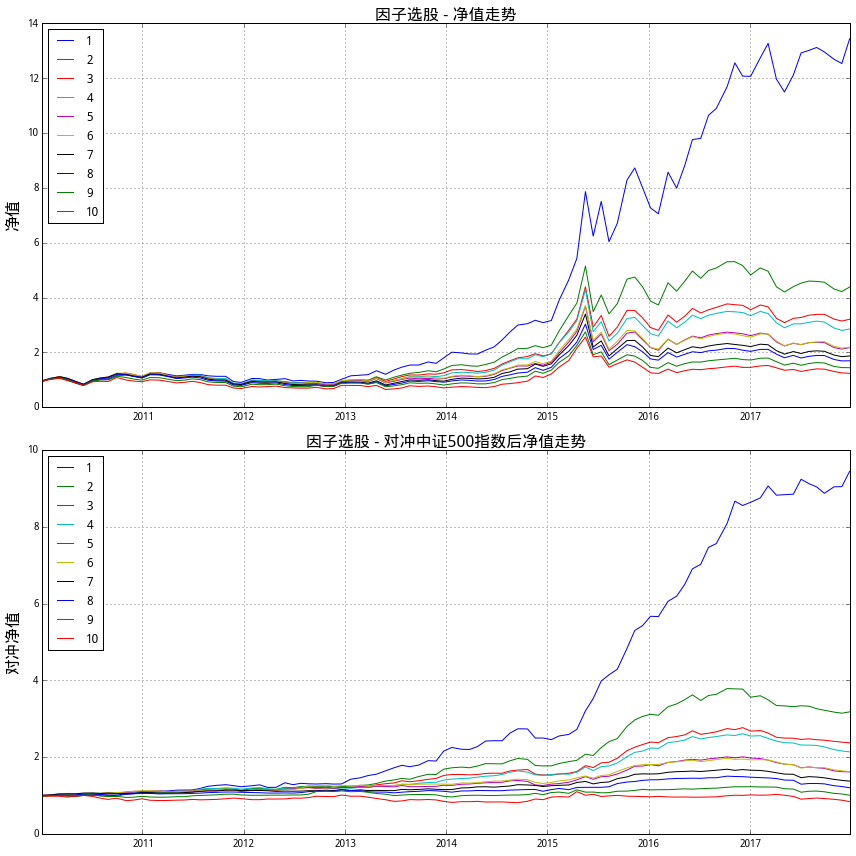

In [58]:
fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
fig.set_tight_layout(True)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.grid()
ax2.grid()

ax1.set_ylabel(u"净值", fontsize=16)
ax2.set_ylabel(u"对冲净值", fontsize=16)
ax1.set_title(u"因子选股 - 净值走势", fontsize=16)
ax2.set_title(u"因子选股 - 对冲中证500指数后净值走势", fontsize=16)

date = map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'),return_data.index)

sequences = return_data.columns[:-1]

# 显示的dataframe
cols = [(u'风险指标', u'Alpha'), (u'风险指标', u'Beta'), (u'风险指标', u'信息比率'), (u'风险指标', u'夏普比率'),
        (u'纯多头', u'年化收益'), (u'纯多头', u'最大回撤'), (u'纯多头', u'收益波动率'), 
        (u'对冲后', u'年化收益'), (u'对冲后', u'最大回撤'), (u'对冲后', u'收益波动率')]
columns = pd.MultiIndex.from_tuples(cols)
result_df = DataFrame(index = sequences,columns=columns)
result_df.index.name = "%s分位组别" % (len(sequences) )

# 对每一个序列进行计算和绘图
for sq in sequences:
    
    # 每期收益
    ret_p_se = return_data[sq]
    ret_m_se = pct_chg_index.ix[return_data.index.tolist()]
    ret_p_excess_se = return_data_excess[sq]
    
    # 净值
    nav = (ret_p_se+1).cumprod()
    nav_excess = (ret_p_excess_se+1).cumprod()
    
    # beta 
    beta = ret_p_se.corr(ret_m_se) * ret_p_se.std() / ret_m_se.std()
    beta_excess = ret_p_excess_se.corr(ret_m_se) * ret_p_excess_se.std() / ret_m_se.std()
    
    # 年化收益
    ann_ret_p = np.power(nav.iloc[-1],1/(1.0*daysPassBy/365)) -1
    ann_ret_p_excess = np.power(nav_excess.iloc[-1],1/(1.0*daysPassBy/365)) -1
    ann_ret_m = np.power((ret_m_se+1).cumprod().iloc[-1],1/(1.0*daysPassBy/365)) -1
    
    # 最大回撤
    max_down = max([1 - v/max(1, max(nav.iloc[:i+1])) for i,v in enumerate(nav)])
    max_down_excess = max([1 - v/max(1, max(nav_excess.iloc[:i+1])) for i,v in enumerate(nav_excess)])
    
    # 策略波动率
    vol = np.sqrt(1.0*12/(len(ret_p_se)-1)*((ret_p_se - ret_p_se.mean())**2).sum())
    vol_excess = np.sqrt(1.0*12/(len(ret_p_excess_se)-1)*((ret_p_excess_se - ret_p_excess_se.mean())**2).sum())
    
    # alpha
    ann_ret_f = 0.04
    alpha = ann_ret_p - (ann_ret_f + beta * (ann_ret_m - ann_ret_f))
    alpha_excess = ann_ret_p_excess - (ann_ret_f + beta_excess * (ann_ret_m - ann_ret_f)) 
    
    # 信息比率
    ir =(ann_ret_p - ann_ret_m) / (np.std(ret_p_se - ret_m_se)*np.sqrt(12))
    # 夏普比率
    sharpe = (ann_ret_p - ann_ret_f) / vol
    
    # 美化打印结果
    alpha = '%.2f%%'%(alpha*100)
    sharpe = round(sharpe,2)
    ir = round(ir,2)
    beta = round(beta,2)
    ann_ret_p = '%.2f%%'%(ann_ret_p*100)
    max_down = '%.2f%%'%(max_down*100)
    vol = '%.2f%%'%(vol*100)
    ann_ret_p_excess = '%.2f%%'%(ann_ret_p_excess*100)
    max_down_excess = '%.2f%%'%(max_down_excess*100)
    vol_excess = '%.2f%%'%(vol_excess*100)
    
    result_df.ix[sq] = [alpha, beta, ir, sharpe, ann_ret_p, max_down, vol, ann_ret_p_excess, max_down_excess, vol_excess]

    # 绘图数据
    ax1.plot(date, nav, label=str(sq))
    ax2.plot(date, nav_excess, label=str(sq))
    





ax1.legend(loc=0, fontsize=12)
ax2.legend(loc=0, fontsize=12)

result_df

## 各个组合超额收益情况

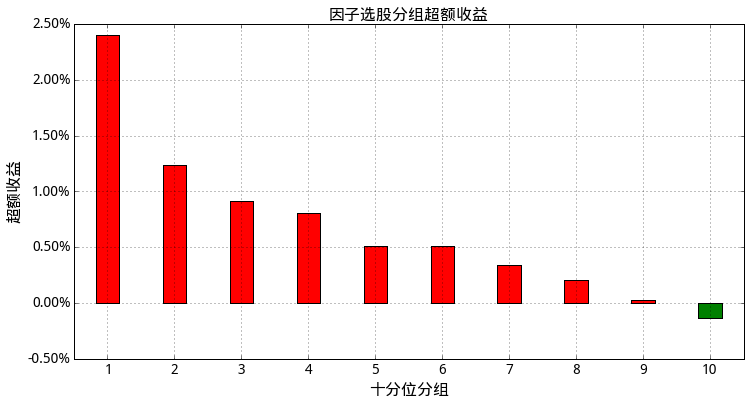

In [59]:
def draw_excess_return(excess_returns_means):
    # 因子分组的超额收益作图
    fig = plt.figure(figsize=(12, 6))
    fig.set_facecolor('white')
    ax1 = fig.add_subplot(111)

    excess_returns_means_dist = excess_returns_means.mean()
    excess_returns_means_dist.index = map(lambda x:int(x),excess_returns_means_dist.index)
    excess_dist_plus = excess_returns_means_dist[excess_returns_means_dist>0]
    excess_dist_minus = excess_returns_means_dist[excess_returns_means_dist<0]
    lns2 = ax1.bar(excess_dist_plus.index, excess_dist_plus.values, align='center', color='r', width=0.35)
    lns3 = ax1.bar(excess_dist_minus.index, excess_dist_minus.values, align='center', color='g', width=0.35)

    ax1.set_xlim(left=0.5, right=len(excess_returns_means_dist)+0.5)
    # ax1.set_ylim(-0.008, 0.008)
    ax1.set_ylabel(u'超额收益', fontsize=16)
    ax1.set_xlabel(u'十分位分组', fontsize=16)
    ax1.set_xticks(excess_returns_means_dist.index)
    ax1.set_xticklabels([int(x) for x in ax1.get_xticks()], fontsize=14)
    ax1.set_yticklabels([str(x*100)+'0%' for x in ax1.get_yticks()], fontsize=14)
    ax1.set_title(u"因子选股分组超额收益", fontsize=16)
    ax1.grid()
    
    return

draw_excess_return(return_data_excess.iloc[:,:10])

## 头部组合收益

In [60]:
return_data = top_return_data[(return_data.index>='2010-01-01') & (return_data.index<='2018-06-01')]

# 指数收益
if index == 'all':
    benchmark = '000905.XSHG'
else:
    benchmark = index
    
priceIndex = get_price(benchmark ,start_date = start, end_date = '2018-02-06', fields='close')
pct_chg_index = (priceIndex.shift(-20) / priceIndex - 1)['close']
pct_chg_index.index = map(lambda x:x.strftime('%Y-%m-%d'),pct_chg_index.index)

# 超额收益
return_data_excess = return_data.copy()
return_data_excess['benchmark'] = 0
return_data_excess['benchmark'].ix[return_data_excess.index] = pct_chg_index.ix[return_data_excess.index]

for i in return_data_excess.iloc[:,:-1]:
    return_data_excess[i] -= return_data_excess['benchmark']
    

风险指标                       纯多头                     对冲后          \
         Alpha  Beta  信息比率  夏普比率    年化收益    最大回撤   收益波动率    年化收益    最大回撤   
20分位组别                                                                     
top10   20.00%  1.12   1.1  0.54  24.53%  46.36%  37.67%  20.66%  19.62%   
top20   23.22%   1.1  1.39  0.65  27.74%  45.02%  36.66%  23.47%  13.84%   
top30   23.03%  1.05  1.58  0.68  27.52%  41.77%  34.35%  22.55%  12.86%   
top40   20.57%  1.05  1.58  0.63  25.06%  42.33%  33.65%  20.18%  12.22%   
top50   20.35%  1.03  1.57  0.63  24.83%  41.72%  33.33%  19.77%  12.63%   
top60   19.07%  1.05  1.52  0.58  23.56%  42.32%  33.52%  18.69%  13.06%   
top70   19.14%  1.06  1.54  0.58  23.63%  41.83%  33.71%  18.84%  14.05%   
top80   19.07%  1.07  1.54  0.57  23.57%  43.01%  34.10%  18.99%  14.15%   
top90   18.83%  1.07  1.57  0.57  23.33%  41.80%  33.79%  18.69%  13.45%   
top100  18.19%  1.07  1.56  0.55  22.70%  42.21%  33.78%  18.14%  12.50%   
top110  17.71%  1.06  1.55  0.54  22.21%  42.58%  33.46%  17.57%  12.53%   
top120  17.48%  1.06  1.54  0.54  21.98%  42.74%  33.39%  17.35%  11.76%   
top130  16.83%  1.06  1.51  0.52  21.32%  42.07%  33.27%  16.70%  12.14%   
top140  16.87%  1.06  1.54  0.52  21.36%  42.32%  33.15%  16.72%  12.14%   
top150  16.28%  1.06   1.5   0.5  20.77%  43.01%  33.24%  16.20%  12.92%   
top160  16.43%  1.06  1.54  0.51  20.92%  42.99%  33.08%  16.30%  12.93%   
top170  15.90%  1.06  1.51   0.5  20.39%  43.10%  33.10%  15.82%  13.09%   
top180  15.98%  1.06  1.53   0.5  20.47%  43.27%  33.06%  15.89%  13.00%   
top190  15.64%  1.06  1.51  0.49  20.14%  43.36%  33.08%  15.59%  12.92%   
top200  14.90%  1.06  1.46  0.47  19.40%  43.31%  33.05%  14.88%  12.53%   

                
         收益波动率  
20分位组别          
top10   18.37%  
top20   16.85%  
top30   14.70%  
top40   13.12%  
top50   13.05%  
top60   12.60%  
top70   12.51%  
top80   12.44%  
top90   12.09%  
top100  11.77%  
top110  11.52%  
top120  11.41%  
top130  11.18%  
top140  11.02%  
top150  10.92%  
top160  10.77%  
top170  10.63%  
top180  10.55%  
top190  10.43%  
top200  10.30%

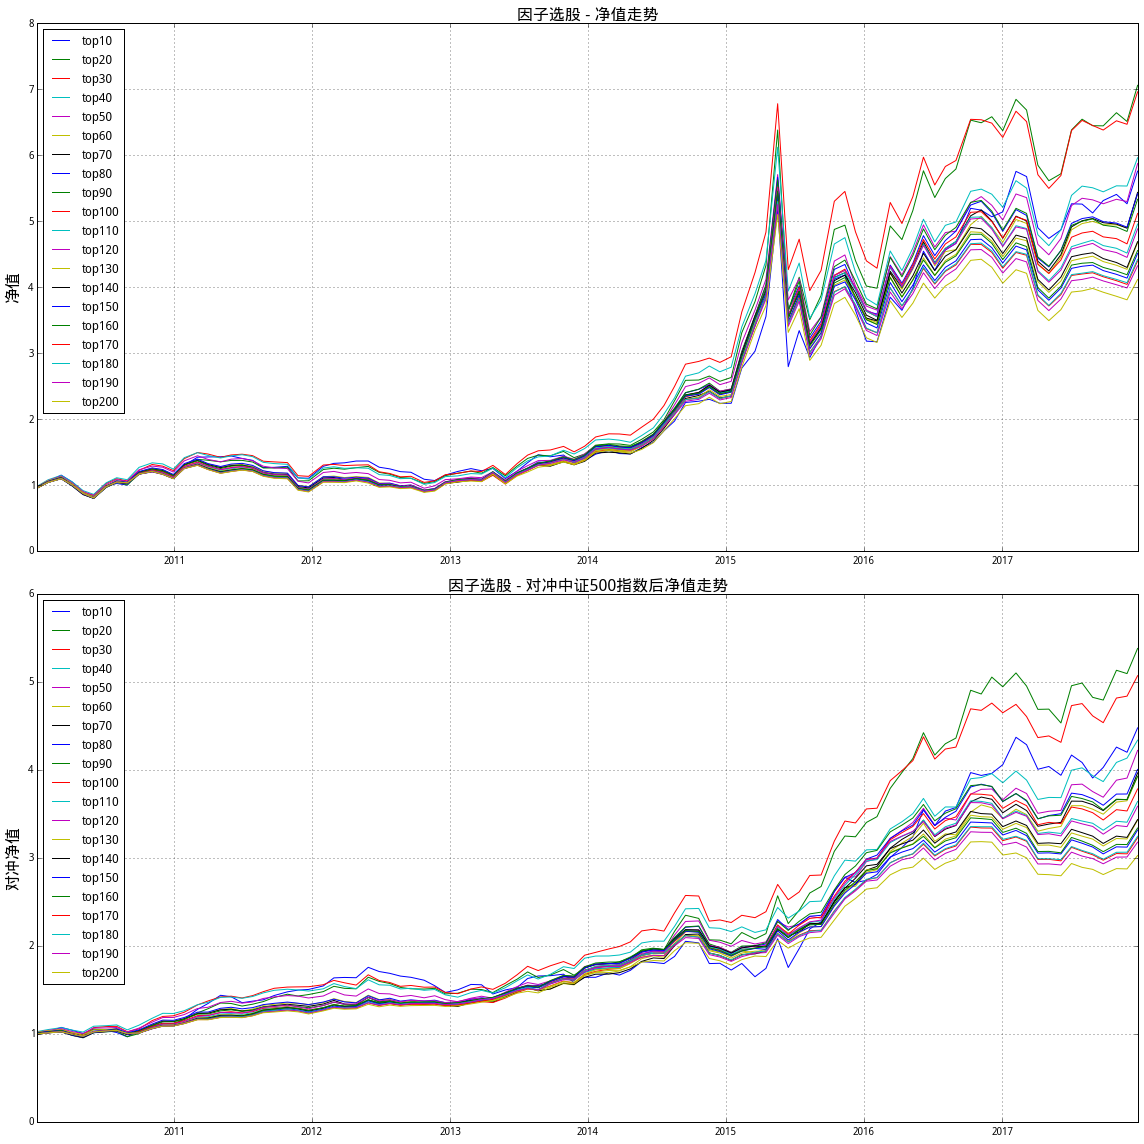

In [61]:
fig = plt.figure(figsize=(16,16))
fig.set_facecolor('white')
fig.set_tight_layout(True)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.grid()
ax2.grid()

ax1.set_ylabel(u"净值", fontsize=16)
ax2.set_ylabel(u"对冲净值", fontsize=16)
ax1.set_title(u"因子选股 - 净值走势", fontsize=16)
ax2.set_title(u"因子选股 - 对冲中证500指数后净值走势", fontsize=16)

date = map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'),return_data.index)

sequences = return_data.columns[:-1]

# 显示的dataframe
cols = [(u'风险指标', u'Alpha'), (u'风险指标', u'Beta'), (u'风险指标', u'信息比率'), (u'风险指标', u'夏普比率'),
        (u'纯多头', u'年化收益'), (u'纯多头', u'最大回撤'), (u'纯多头', u'收益波动率'), 
        (u'对冲后', u'年化收益'), (u'对冲后', u'最大回撤'), (u'对冲后', u'收益波动率')]
columns = pd.MultiIndex.from_tuples(cols)
result_df = DataFrame(index = sequences,columns=columns)
result_df.index.name = "%s分位组别" % (len(sequences) )

# 对每一个序列进行计算和绘图
for sq in sequences:
    
    # 每期收益
    ret_p_se = return_data[sq]
    ret_m_se = pct_chg_index.ix[return_data.index.tolist()]
    ret_p_excess_se = return_data_excess[sq]
    
    # 净值
    nav = (ret_p_se+1).cumprod()
    nav_excess = (ret_p_excess_se+1).cumprod()
    
    # beta 
    beta = ret_p_se.corr(ret_m_se) * ret_p_se.std() / ret_m_se.std()
    beta_excess = ret_p_excess_se.corr(ret_m_se) * ret_p_excess_se.std() / ret_m_se.std()
    
    # 年化收益
    ann_ret_p = np.power(nav.iloc[-1],1/(1.0*daysPassBy/365)) -1
    ann_ret_p_excess = np.power(nav_excess.iloc[-1],1/(1.0*daysPassBy/365)) -1
    ann_ret_m = np.power((ret_m_se+1).cumprod().iloc[-1],1/(1.0*daysPassBy/365)) -1
    
    # 最大回撤
    max_down = max([1 - v/max(1, max(nav.iloc[:i+1])) for i,v in enumerate(nav)])
    max_down_excess = max([1 - v/max(1, max(nav_excess.iloc[:i+1])) for i,v in enumerate(nav_excess)])
    
    # 策略波动率
    vol = np.sqrt(1.0*12/(len(ret_p_se)-1)*((ret_p_se - ret_p_se.mean())**2).sum())
    vol_excess = np.sqrt(1.0*12/(len(ret_p_excess_se)-1)*((ret_p_excess_se - ret_p_excess_se.mean())**2).sum())
    
    # alpha
    ann_ret_f = 0.04
    alpha = ann_ret_p - (ann_ret_f + beta * (ann_ret_m - ann_ret_f))
    alpha_excess = ann_ret_p_excess - (ann_ret_f + beta_excess * (ann_ret_m - ann_ret_f)) 
    
    # 信息比率
    ir =(ann_ret_p - ann_ret_m) / (np.std(ret_p_se - ret_m_se)*np.sqrt(12))
    # 夏普比率
    sharpe = (ann_ret_p - ann_ret_f) / vol
    
    # 美化打印结果
    alpha = '%.2f%%'%(alpha*100)
    sharpe = round(sharpe,2)
    ir = round(ir,2)
    beta = round(beta,2)
    ann_ret_p = '%.2f%%'%(ann_ret_p*100)
    max_down = '%.2f%%'%(max_down*100)
    vol = '%.2f%%'%(vol*100)
    ann_ret_p_excess = '%.2f%%'%(ann_ret_p_excess*100)
    max_down_excess = '%.2f%%'%(max_down_excess*100)
    vol_excess = '%.2f%%'%(vol_excess*100)
    
    result_df.ix[sq] = [alpha, beta, ir, sharpe, ann_ret_p, max_down, vol, ann_ret_p_excess, max_down_excess, vol_excess]

    # 绘图数据
    ax1.plot(date, nav, label=str(sq))
    ax2.plot(date, nav_excess, label=str(sq))
    





ax1.legend(loc=0, fontsize=12)
ax2.legend(loc=0, fontsize=12)

result_df

## 市值分布情况

In [62]:
# 计算因子分组的市值分位数平均值
def quantile_mkt_values(signal_df, mkt_df):
    n_quantile = 10
    # 统计十分位数
    cols_mean = [i+1 for i in range(n_quantile)]
    cols = cols_mean

    mkt_value_means = pd.DataFrame(index=signal_df.index, columns=cols)

    # 计算相关系数分组的市值分位数平均值
    for dt in mkt_value_means.index:
        if dt not in mkt_df.index:
            continue 
        qt_mean_results = []

        # 相关系数去掉nan和绝对值大于0.97的
        tmp_factor = signal_df.ix[dt].dropna()
        tmp_mkt_value = mkt_df.ix[dt].dropna()
        tmp_mkt_value = tmp_mkt_value.rank()/len(tmp_mkt_value)

        pct_quantiles = 1.0/n_quantile
        for i in range(n_quantile):
            down = tmp_factor.quantile(pct_quantiles*i)
            up = tmp_factor.quantile(pct_quantiles*(i+1))
            i_quantile_index = tmp_factor[(tmp_factor<=up) & (tmp_factor>=down)].index
            mean_tmp = tmp_mkt_value[i_quantile_index].mean()
            qt_mean_results.append(mean_tmp)
        mkt_value_means.ix[dt] = qt_mean_results
    mkt_value_means.dropna(inplace=True)
    return mkt_value_means.mean()



    

In [63]:
filename_factor_data_avg_dict = 'data/backPro/{0}_{1}m_factor_data_avg_dict.pkl'.format(index[:6], months)
body = read_file(filename_factor_data_avg_dict)
factor_data_avg_dict = pickle.load(StringIO(body))
# 因子数据
factor_data_avg = pd.Panel(factor_data_avg_dict)[:,:,0].T

date_str_list_to_compute = factor_data_avg.index.tolist()

facStr = 'MC'
factor_dict = {} 
year_list = range(2007,2018)
facType = 'finance'
for year in year_list:
    filename = 'data/factors/%s/factor_datas_%s_%s.pkl' % (facType, facStr, year)
    # 读取文件
    body = read_file(filename)
    factor_dict_temp = pickle.load(StringIO(body))
    date_str_list_temp = filter(lambda x:x not in date_str_list_to_compute,factor_dict_temp.keys())
    for date_str in date_str_list_temp:
        del factor_dict_temp[date_str]
    factor_dict.update(factor_dict_temp)
    del factor_dict_temp

mkt_value_data = pd.Panel(factor_dict)[:,:,0].T
del factor_dict

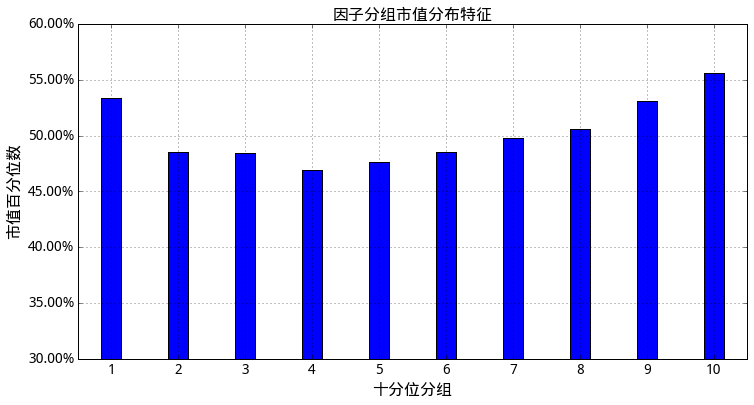

In [64]:
mkt_value_data_tmp = mkt_value_data[(mkt_value_data.index >= '2017-01-01') & (mkt_value_data.index <= '2017-12-31')]


# 计算因子分组的市值分位数平均值
origin_mkt_means = quantile_mkt_values(factor_data_avg, mkt_value_data_tmp)

# 因子分组的市值分位数平均值作图
fig = plt.figure(figsize=(12, 6))
fig.set_facecolor('white')
ax1 = fig.add_subplot(111)

width = 0.3
lns1 = ax1.bar(origin_mkt_means.index, origin_mkt_means.values, align='center', width=width)

ax1.set_ylim(0.3,0.6)
ax1.set_xlim(left=0.5, right=len(origin_mkt_means)+0.5)
ax1.set_ylabel(u'市值百分位数', fontsize=16)
ax1.set_xlabel(u'十分位分组', fontsize=16)
ax1.set_xticks(origin_mkt_means.index)
ax1.set_xticklabels([int(x) for x in ax1.get_xticks()], fontsize=14)
ax1.set_yticklabels([str(x*100)+'0%' for x in ax1.get_yticks()], fontsize=14)
ax1.set_title(u"因子分组市值分布特征", fontsize=16)
ax1.grid()
